## Badanie Dna Oka
- Adrian Kellner (141245)
- Adam Marciniak (141273)

### Założenia projektu:

Algorytm w podstawowej wersji powinien wykorzystywać techniki przetwarzania obrazu (poznane między innymi na przedmiocie KCK – zadanie z samolotami/projekt z obrazów) do detekcji naczyń krwionośnych. W ramach takiego procesu przetwarzania można wyróżnić 3 główne elementy:
* Wstępne przetworzenie obrazu: wejściowy obraz może być zaszumiony/zbyt ciemny/jasny. Można tutaj wykorzystać takie techniki jak: rozmycie, wyostrzenie, normalizacja histogramu kolorów itp. 
* Właściwe przetworzenie obrazu: w celu wyodrębnienia naczyń krwionośnych: można zastosować różne techniki wykrywania krawędzi (np. filtr Frangi’ego). 
Końcowe przetwarzanie obrazu: przetwarzanie uzyskanego obrazu w celu poprawy skuteczności wykrywania naczyń poprzez “naprawę” błędów z poprzednich kroków. 
* Wynik obowiązkowo należy wizualizować np. zamalowując wyróżniającym się kolorem piksele zaklasyfikowane jako naczynie krwionośne. W tym celu najlepiej wygenerować binarną maskę odpowiedzi algorytmu, która zostanie potem wykorzystana do analizy statystycznej (porównanie z maską ekspercką z ręcznie zaznaczonymi naczyniami).


Ważnym elementem oceny jest skuteczność algorytmu. W tym celu należy dokonać podstawowej analizy statystycznej jakości działania algorytmu. Działanie programu należy przetestować na minimum 5 obrazach. Podczas testów należy wyznaczyć macierze pomyłek oraz takie miary jak trafność (accuracy), czułość (sensitivity), swoistość (specificity).

Przy wyznaczaniu czułości i swoistości należy założyć, że naczynie to klasa pozytywna, a tło - negatywna. Ponieważ mamy do czynienia z niezrównoważonym rozkładem klas (punktów tła jest znacznie więcej niż naczyń) należy dodatkowo wykorzystać miary dla danych niezrównoważonych (np. średnią arytmetyczną lub geometryczną czułości i swoistości). 



Image upload:

In [ ]:
from google.colab import files
files.upload()

Saving 01_h.jpg to 01_h.jpg
Saving 01_h.tif to 01_h.tif
Saving 02_h.jpg to 02_h.jpg
Saving 02_h.tif to 02_h.tif
Saving 03_h.jpg to 03_h.jpg
Saving 03_h.tif to 03_h.tif
Saving 04_h.jpg to 04_h.jpg
Saving 04_h.tif to 04_h.tif
Saving 05_h.jpg to 05_h.jpg
Saving 05_h.tif to 05_h.tif
Saving 06_h.jpg to 06_h.jpg
Saving 06_h.tif to 06_h.tif


Imports:

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
from skimage import io, filters
from skimage import morphology as mp
from skimage.util import invert
import cv2
from cv2 import morphologyEx as mpEx
from PIL import Image, ImageOps

Display-related functions:

In [ ]:
def compare_images(img1, name1, img2, name2, used_cmap='gray'):
    # plot two images together for visual comparison
    fig = plt.figure(figsize=(14, 4), dpi=100)

    sub1 = fig.add_subplot(121)
    sub1.set_title(f"{name1}")
    sub1.set_xlabel("x")
    sub1.set_ylabel("y")
    sub1.imshow(img1, cmap=used_cmap)

    sub2 = fig.add_subplot(122)
    sub2.set_title(f"{name2}")
    sub2.set_xlabel("x")
    sub2.set_ylabel("y")
    sub2.imshow(img2, cmap=used_cmap)

    plt.show()


def single_image(img, name, used_cmap='gray'):
    fig = plt.figure(figsize=(8, 6), dpi=100)
    sub1 = fig.add_subplot(111)
    sub1.set_title(f"{name}")
    sub1.set_xlabel("x")
    sub1.set_ylabel("y")
    sub1.imshow(img, cmap=used_cmap)
    plt.show()


def highlight_differences(result, manual):
    # find pixel differences between two images
    y_size = result.shape[0]
    x_size = result.shape[1]
    image_out = np.zeros((y_size, x_size, 3))
    for y in range(y_size):
        for x in range(x_size):
            # mark common pixels as white
            if result[y][x] > 0.0 and manual[y][x] > 0.0:
                image_out[y][x][:] = 1
            # mark pixels missing from result image as cyan 
            elif result[y][x] == 0.0 and manual[y][x] > 0.0:
                image_out[y][x][1:] = 1
            # mark incorrectly marked pixels as red
            elif result[y][x] > 0.0 and manual[y][x] == 0.0:
                image_out[y][x][0] = 1

    return image_out


def quicker_differences(result, eq, neq, pos, neg):
    # find pixel differences between two images
    y_size = result.shape[0]
    x_size = result.shape[1]
    image_out = np.zeros((y_size, x_size, 3))
    # mark common pixels as white
    image_out[eq & pos, :] = 1
    # mark pixels missing from result image as cyan
    image_out[neq & neg, 1:] = 1
    # mark incorrectly marked pixels as red
    image_out[neq & pos, 0] = 1
    return image_out


def calculate_statistics(result, manual):
    result = normalize(result)
    manual = normalize(manual)

    equal_mask = (result == manual)
    nonequal_mask = (result != manual)
    positive_mask = (result == 1)
    negative_mask = (result == 0)

    tp = np.sum(equal_mask & positive_mask)
    fp = np.sum(nonequal_mask & positive_mask)
    fn = np.sum(nonequal_mask & negative_mask)
    tn = np.sum(equal_mask & negative_mask)

    accuracy = (tp + tn) / (tp + fp + fn + tn) * 100
    sensitivity = tp / (tp + fn) * 100
    specificity = tn / (fp + tn) * 100

    error_image = quicker_differences(result, equal_mask, nonequal_mask,
                                           positive_mask, negative_mask)
    
    # 'Tp': tp,
    # 'Fp': fp,
    # 'Fn': fn,
    # 'Tn': tn,
    stats = {
        'Accuracy': accuracy,
        'Sensitivity': sensitivity,
        'Specificity': specificity
    }
    return stats, error_image

Image processing-related functions:

In [ ]:
def rgb_split(image):
    # split image into 3 channels, return [r,g,b] array
    image = Image.Image.split(image)
    channels = [np.asarray(channel) for channel in image]
    return channels


def normalize(img):
    # readjust range of pixel values to <0,1>
    max_value = np.max(img)
    min_value = np.min(img)
    if max_value == min_value:
      return img
    normalized_img = (img - min_value) / (max_value - min_value)
    return normalized_img   


def dilate_wrap(image, k_size=3):
    # perform dilation with custom kernel
    kernel = np.ones((k_size, k_size), np.uint8)
    dilated = cv2.dilate(np.float32(image), kernel)
    return dilated


def erode_wrap(image, k_size=3):
    # perform erosion with custom kernel
    kernel = np.ones((k_size, k_size), np.uint8)
    eroded = cv2.erode(np.float32(image), kernel)
    return eroded


def open_wrap(image, k_size=5):
    # perform opening with custom kernel
    kernel = np.ones((k_size, k_size), np.uint8)
    open_img = mpEx(image, cv2.MORPH_OPEN, kernel)
    return open_img


def close_wrap(image, k_size=5):
    # perform closing with custom kernel
    kernel = np.ones((k_size, k_size), np.uint8)
    close_img = mpEx(image, cv2.MORPH_CLOSE, kernel)
    return close_img


def open_n_close(image, k_size=5):
    # perform opening and then closing with custom kernel
    open_img = open_wrap(image, k_size)
    close_img = close_wrap(open_img, k_size)
    return close_img


def threshold(image, t=0.5):
    # create binary image with hard-defined threshold value
    binary = (normalize(image) > t)
    binary = np.uint8(binary)
    return binary


def adaptive_threshold(image, v=0.0):
    # create binary image with threshold value based on image's percentile pixel value
    threshold = np.percentile(image, v)
    # binary = image > threshold
    new = np.zeros(image.shape)
    new[image[:,:] > threshold1] = 1
    new[image[:,:] < threshold] = 0
    return image


def hysteresis_threshold(image, v=90.0):
    # perform adaptive thresholding with additional hystresis
    upper_t = np.percentile(image, v)
    lower_t = np.max(image) - upper_t
    if lower_t < 0.0:
        lower_t = 0.0
    hyst_map = filters.apply_hysteresis_threshold(image, lower_t, upper_t)
    image_t = (image > upper_t).astype(np.uint8)
    hyst = normalize(image_t + hyst_map)
    return hyst


def otsu_mask(image, k_size=5):
    # create mask based on otsu thresholding
    gauss = np.uint8(cv2.GaussianBlur(image, (k_size,k_size), 0))
    t_val, otsu = cv2.threshold(gauss,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    return otsu


def auto_canny(image, sigma=0.11):
    # perform canny edge detection with adaptive threshold values
    image = np.uint8(normalize(image) * 255)
    v = np.median(image)
    lower_t = int(max(0, (1.0 - sigma) * v))
    upper_t = int(min(255, (1.0 + sigma) * v))
    filtered = cv2.Canny(image, lower_t, upper_t)
    return filtered


def apply_frangi(image):
    # perform frangi edge detection
    out = filters.frangi(image, sigmas=range(1, 10, 2), alpha=2.0)
    out = normalize(out)
    return out


def perform_clahe(green_channel):
    # CLAHE:  Contrast Limited Adaptive Histogram Equalization
    green_channel = np.uint8(normalize(green_channel) * 255)
    clahe = cv2.createCLAHE(clipLimit = 2, tileGridSize=(8,8))
    clahed = clahe.apply(green_channel) #+ 30
    final_img = normalize(clahed)
    return final_img


def create_mask(red_channel):
    # creates mask based on light areas of channel/image
    mask = adaptive_threshold(normalize(red_channel))
    mask = mp.erosion(mask, mp.star(4))
    mask = invert(mask)
    return mask


def apply_mask(image, mask):
    # blacks-out image pixels which are covered by the mask
    image[mask > 0.0] = 0
    return image


def high_boost_filter(image, k_size=7):
    # enhances high-frequency components of image
    gauss = cv2.GaussianBlur(image, (k_size,k_size), 0)
    out = normalize(cv2.addWeighted(image, 2, gauss, -1, 0))
    return out

Big boy function:

In [ ]:
def process_image(image, show_comparisons):
    print("Preprocessing image...")

    # Splitting `image` into 3 rgb channels
    channels = rgb_split(image)
    red, green, blue = channels
    
    # Performing clahe and morphological filtering on green channel
    processed_green =  perform_clahe(green)
    processed_green =  normalize(open_n_close(processed_green))

    # Creating mask from red channel and applying it to processed green channel
    mask = create_mask(red)
    masked = apply_mask(processed_green, mask)

    # Using high boost filter to help highlight image features
    prepr = high_boost_filter(masked)

    print("Applying Frangi and postprocessing...")

    # Frangi + amping
    frangi = apply_frangi(prepr)
    frangi_hys = normalize(hysteresis_threshold(frangi, 87.5))
    frangi_hys = apply_mask(frangi_hys, mask)
    frangi_hys = close_wrap(frangi_hys, 7)
    
    # Postprocessing steps performed on another copy of `prepr` image
    unsharped = filters.unsharp_mask(prepr, 15, 3)
    unsharped = apply_mask(unsharped, mask)
    #otsu_t = otsu_mask(unsharped, 5)
    otsu_t = filters.threshold_otsu(unsharped)
    image_t = (unsharped <= otsu_t).astype(np.uint8)
    image_t = dilate_wrap(image_t, 3)
    image_t = open_n_close(image_t, 3)
    image_t = erode_wrap(image_t, 3)

    # AND operation
    image_out = cv2.bitwise_and(np.uint8(frangi_hys), np.uint8(image_t))
    image_out = normalize(threshold(image_out, 0.5))

    print("Process finished! Preparing results...")

    if show_comparisons:
        compare_images(green, "Green", processed_green, "Processed Green", 'Greens')
        compare_images(red, "Red", mask, "Mask", 'Reds')
        compare_images(frangi_hys, "Frangi applied", image_t, "Postprocessed, before AND operation", 'gray')

    return image_out

Run!

Preprocessing image...
Applying Frangi and postprocessing...
Process finished! Preparing results...


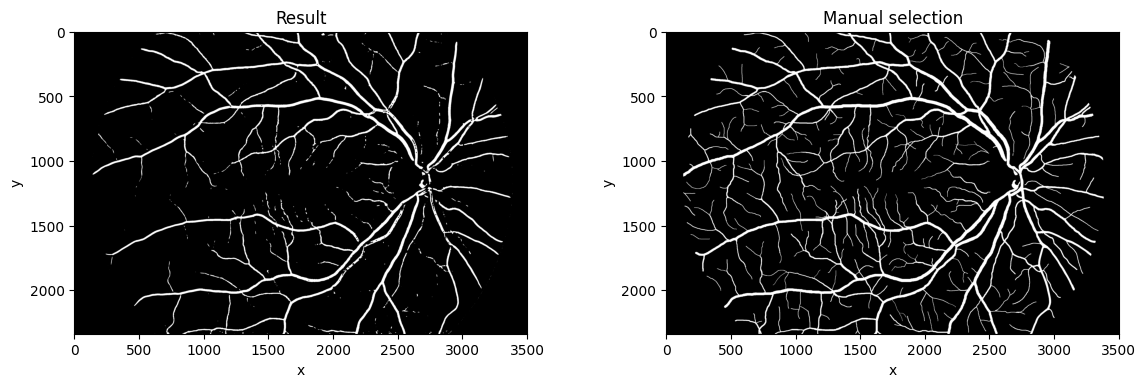

Calculating statistics...
Accuracy: 95.79278525129793
Sensitivity: 62.38535630684217
Specificity: 99.58224602038018


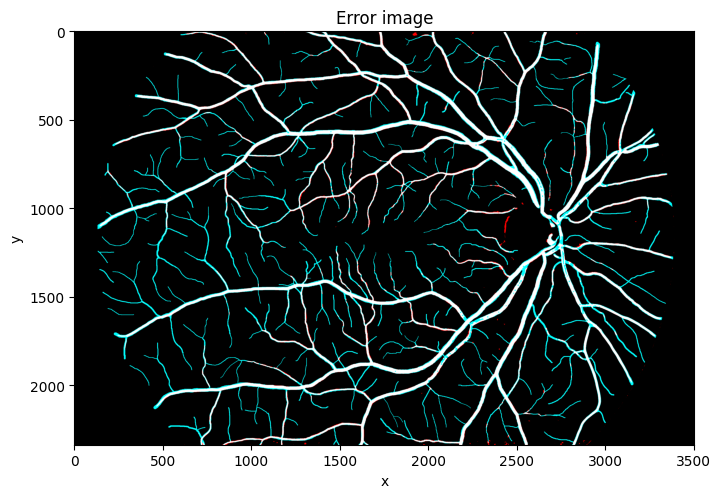

In [ ]:
calculate_stats = True
image = Image.open("01_h.jpg")
manual = np.asarray(Image.open("01_h.tif"))
result = process_image(image, show_comparisons=False)
compare_images(result, "Result", manual, "Manual selection")

if calculate_stats:
    print("Calculating statistics...")
    stats, error_image = calculate_statistics(result, manual)
    for key, item in stats.items():
        print(f"{key}: {item}")

    single_image(error_image, "Error image", 'gray')

### Wymagania na 4.0

- Po wstępnym przetworzeniu obrazu należy podzielić go na wycinki (np. 5x5 px) i dla każdej z nich dokonać ekstrakcji cech z obrazu: np. wariancja kolorów, momenty centralne, momenty Hu itp. Wartości te wraz z informacją pochodzącą z maski eksperckiej (decyzja dla środkowego piksela wycinka) stanowić będą zbiór danych wykorzystany do budowy wybranego klasyfikatora, prostszego niż głęboka sieć neuronowa (np. kNN, drzewo lub las decyzyjny, SVM). Należy skorzystać z gotowej implementacji klasyfikatora (np. w bibliotece scikit-learn).
- Z uwagi na ograniczenia pamięciowe konieczne może być ograniczenie rozmiaru zbioru uczącego poprzez losowy wybór punktów (możliwość zastosowania undersampling-u do zrównoważenia rozkładu klas w zbiorze uczącym).
- Zdolności predykcyjne tak opracowanego klasyfikatora należy wstępnie zweryfikować na niezależnym zbiorze testowym hold-out (np. pochodzącym z innej części obrazu lub z innego obrazu). 
- Gotowy klasyfikator powinien zostać osadzony w aplikacji, a jego działanie powinno zostać zwizualizowane i przetestowane w taki sam sposób, jak działanie technik przetwarzania obrazu z wymagań podstawowych..


In [ ]:
from scipy.stats import moment
import sklearn.neighbors
from sklearn.neighbors import KNeighborsClassifier
import random
from sklearn.metrics import mean_squared_error
from math import sqrt


In [ ]:
def prepro(image):
    # Splitting `image` into 3 rgb channels
    channels = rgb_split(image)
    red, green, blue = channels
    
    # Performing clahe and morphological filtering on green channel
    processed_green =  perform_clahe(green)
    processed_green =  normalize(open_n_close(processed_green))

    # Creating mask from red channel and applying it to processed green channel
    mask = create_mask(red)
    masked = apply_mask(processed_green, mask)

    # Using high boost filter to help highlight image features
    out = high_boost_filter(masked)

    return out

def img_split(img, size = 5):
  pieces = []
  for i in range(0, img.shape[0] - size + 1, size):
    for j in range(0, img.shape[1] - size + 1, size):
      pieces.append(img[i:i+size,j:j+size])
  return pieces

def img_split_v2(img, a, b, c, d):
  pieces = []
  for i in range(a, b):
    for j in range(c, d):
      pieces.append(img[i:i+PATCH_SIZE,j:j+PATCH_SIZE])
  return pieces

def crop_manual_v1(img, size = 5):
  out = []
  for i in range(size//2, img.shape[0] - size//2, size):
    for j in range(size//2, img.shape[1] - size//2, size):
      out.append(img[i][j])
  return out

def color_var(img):
  pass

def hu_moments(img, k = 6):
  return cv2.HuMoments(cv2.moments(threshold(img))).flatten()[:k]

def data_frame(p):
  return [np.mean(p), np.std(p), moment(p, moment=2, axis=None), moment(p, moment=3, axis=None), *hu_moments(p)]

In [ ]:
def prepare_train_data(file = ["04_h"]):
  manual = []
  pcs = []
  for f in file:
    print("Segementing file " + f + "...")
    im = Image.open(f + ".jpg")
    ppim = prepro(im)
    pcs += img_split(ppim, PATCH_SIZE)

    manual += crop_manual_v1(np.asarray(Image.open(f + ".tif")), PATCH_SIZE)
    # X += [data_frame(p) for p in pcs]

  positive = [i for i, x in enumerate(manual) if x]
  negative = [i for i, x in enumerate(manual) if x==0]

  if len(positive) < len(manual)/2:
    sample_of_neg = random.sample(negative, len(positive))
    # sample_of_neg = negative
    print("Computng data of positive pixels...")
    train_X = [data_frame(pcs[p]) for _, p in enumerate(positive)]
    print("Computng data of negative pixels...")
    train_X += [data_frame(pcs[p]) for _, p in enumerate(sample_of_neg)]

    train_Y = [manual[i] for _, i in enumerate(positive)]
    train_Y += [manual[i] for _, i in enumerate(sample_of_neg)]

    print("done")
    return train_X, train_Y
  else:
    print("there would be more positive pixels than negative, it's unlikely, so it's not implemented")
    return [], []

def test_img(file = "05_h", w = 0, x = 1, y = 0, z = 1):
  im = Image.open(file + ".jpg")
  ppim = prepro(im)
  a, b, c, d = int(w*ppim.shape[0]), int(x*ppim.shape[0]), int(y*ppim.shape[1]), int(z*ppim.shape[1])
  print(str(a)+' '+str(b)+' '+str(c)+' '+str(d))
  pcs = img_split_v2(ppim, a, b, c, d)
  # print(len(pcs))

  manual = np.asarray(Image.open(file + ".tif"))
  a += BORDER
  b += BORDER
  c += BORDER
  d += BORDER
  manual = np.array([m[c:d] for m in manual[a:b]])
  # manual[a:b][c:d]
  print(manual.shape)
  X = [data_frame(p) for p in pcs]
  width = d-c
  return X, manual.flatten(), width

In [ ]:
def stats2(test_preds, test_Y):
  print("Calculating statistics...")


  stats, error_image = calculate_statistics(test_preds,test_Y)
  for key, item in stats.items():
      print(f"{key}: {item}")

  test_preds = normalize(test_preds)
  test_Y = normalize(test_Y)
  
  equal_mask = (test_preds == test_Y)
  nonequal_mask = (test_preds != test_Y)
  positive_mask = (test_preds == 1)
  negative_mask = (test_preds == 0)

  tp = np.sum(equal_mask & positive_mask)
  fp = np.sum(nonequal_mask & positive_mask)
  fn = np.sum(nonequal_mask & negative_mask)
  tn = np.sum(equal_mask & negative_mask)

  print("tp: " + str(tp))
  print("fp: " + str(fp))
  print("fn: " + str(fn))
  print("tn: " + str(tn))
  return error_image

In [ ]:
def back_to_2d(arr, width = 700):
  pic = np.array([arr[i:i+width] for i in range(0, len(arr), width)])
  return pic
def plotting2(im, test_preds, test_Y, error_image):
  figg = plt.figure(figsize=(8, 6), dpi=100)

  subb = figg.add_subplot(221)
  subb.set_title("Wejście")
  subb.imshow(im)

  subb = figg.add_subplot(222)
  subb.set_title("Wynik")
  subb.imshow(test_preds, cmap='gray')

  subb = figg.add_subplot(223)
  subb.set_title("Maska ekspercka")
  subb.imshow(test_Y, cmap='gray')

  subb = figg.add_subplot(224)
  subb.set_title("Error image")
  subb.imshow(error_image)

In [ ]:
PATCH_SIZE = 9
BORDER = (PATCH_SIZE-1)//2

train_X, train_Y = prepare_train_data(file=["01_h","02_h","03_h","04_h"])
model = KNeighborsClassifier(n_neighbors=9)
model.fit(train_X, train_Y)


Segementing file 01_h...
Segementing file 02_h...
Segementing file 03_h...
Segementing file 04_h...
Computng data of positive pixels...
Computng data of negative pixels...
done


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=9, p=2,
                     weights='uniform')

0 654 0 981
(654, 981)
Calculating statistics...
Accuracy: 92.70590765835274
Sensitivity: 66.28060489678349
Specificity: 94.15384564797795
tp: 22090
fp: 35559
fn: 11238
tn: 572687
(2336, 3504, 3)


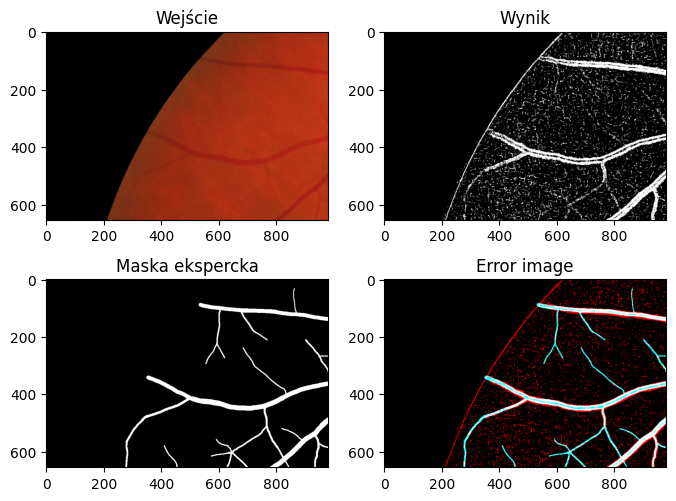

In [ ]:
w,x,y,z = 0.0, 0.28, 0.0, 0.28 # % part of image
test_X, test_Y, width = test_img("05_h", w, x, y, z)
test_preds = model.predict(test_X)

test_preds2 = back_to_2d(test_preds, width)
test_Y2 = back_to_2d(test_Y, width)

error_image = stats2(test_preds2, test_Y2)
original = np.array(Image.open("05_h.jpg"))
print(original.shape)
w *= original.shape[0]
x *= original.shape[0]
y *= original.shape[1]
z *= original.shape[1]
w = int(w)
x = int(x)
y = int(y)
z = int(z)
original = np.array([m[y:z] for m in original[w:x]])
plotting2(original, test_preds2, test_Y2, error_image)